<img src="gwfish_white.png" width="200" height="200">

# Welcome to `GWFish` tutorial!

# Starter: GW data analysis
Bayesian gravitational wave data analysis is used to infer the properties of gravitational wave sources and make predictions about their parameters. It combines the principles of Bayesian statistics with the analysis of gravitational wave signals detected by ground-based observatories like LIGO and Virgo.

The goal of Bayesian gravitational wave data analysis is to extract this information from the noisy gravitational wave signals detected by the observatories:
$$s(t) = h_0(t) + n(t)$$
where $h_0(t)$ is the true (unknown) signal and $n(t)$ is the detector noise, assumed to be Gaussian and stationary.

Mathematically, Bayes' theorem can be expressed as:

$$p(\vec{\theta}|s) \propto \pi(\vec{\theta}){\mathcal{L}}(s|\vec{\theta})$$

where $p(\vec{\theta}|d)$ is the posterior distribution, ${\mathcal{L}}(d|\vec{\theta})$ is the likelihood function, $\pi(\vec{\theta})$ is the prior distribution, and we neglected the evidence or marginal likelihood at the denominator.

To perform Bayesian gravitational wave data analysis, we use various techniques such as Markov Chain Monte Carlo (MCMC) sampling and nested sampling. The mostly used software is `bilby`.
 


# Fisher-matrix approximation

The gravitational-wave likelihood is defined as the probability of noise realization:

$$ {\mathcal{L}}(d|\vec{\theta}) \propto \exp\left[-\frac{1}{2}\langle s - h(\vec{\theta})| s - h(\vec{\theta}) \rangle \right] $$

The inner product $\langle \cdot|\cdot\rangle$ measures the overlap between two signals given the noise characteristics of the detector:

$$ \langle a, b \rangle \equiv 4\operatorname{Re}\int_{f_{\rm min}}^{f_{\rm max}} \frac{\tilde{a}(f)\tilde{b}^*(f)}{S_n(f)}df $$

We can approximate the likelihood by expanding the template around the true signal:

$$ h(\vec{\theta})  = h_0 + \Delta \theta^i h_i$$

so that the likelihood becomes a **multivariarte Gaussian distribution**:

$$ p(\vec{\theta}|s)\propto \pi(\vec{\theta}) \exp\left[-\frac{1}{2}\langle n|n\rangle + \Delta \theta^k\langle n|h_k\rangle - \frac{1}{2}\Delta \theta^i \langle h_i|h_j\rangle \Delta \theta^j \right] $$

1. The truncation in the expansion is done at first-order in partial derivatives, known as **linearized signal approximation** (LSA)
2. LSA approximation is equivalent to the leading term in **posterior expansion as a series in 1/SNR** (this is the reason why Fisher matrix is said to work in high-SNR limit) [see Vallisneri 2008]

In Fisher matrix context we usually work in zero-noise approximation, so that the first two terms cancel and we define the Fisher matrix as:
$$ F_{ij} = \langle h_i|h_j\rangle$$


The Fisher likelihood is therefore simply given by:

$$ {\mathcal{L}} \propto \exp\left[-\frac{1}{2} \left(\vec{\theta} - \vec{\theta}_{\rm inj}\right)^{\rm T} F \left(\vec{\theta} - \vec{\theta}_{\rm inj}\right) \right] $$

The inverse of the Fisher matrix gives us the covariance matrix among parameters:

$$ \sigma_i = \sqrt{\Sigma_{ii}} \ \leftrightarrow  \Sigma_{ij} = \left[F^{-1}\right]_{ij}$$

This is the basic math behind Fisher matrix codes, like `GWFish`


## GWFish
The implementation of Fisher matrix approximation relies on three main pillars:
1. Analytic **waveform approximation** (`lalsimulation`)
2. **Derivatives**
3. **Matrix inversion**

### A note on characteristic strain
The characteristic strain is a particular combination of signal/ASD with frequency so that the output is adimensional and the area in between the signal and the detector's densitivity curve can be interpreted as SNR:

$$
SNR^2 = 4\int\frac{h(f)h^*(f)}{S_n}df
$$

Therefore:

$$
h_c = 2f|h| \quad \text{and} \quad S_c = \sqrt{f}\sqrt{PSD}
$$

# How to use the `GWFish` code

### Set up conda environment [suggested]
`conda create -n gwfish_priors_env python-3.10`


### Install GWFish
To make GWFish modules available from any location in your PC, after clonig the repository
```
git clone git@github.com:janosch314/GWFish.git
```
from the folder location and within the conda environment, execute the command
```
pip install .
```

In [28]:
import GWFish.modules as gw

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
import json
import os
from astropy.cosmology import Planck18

## GWFish in 2 functions
GWfish allows for 2 main functions for ordinary analysis:
- ```compute_network_errors```
- ```analyze_and_save_to_txt```

The output is the same, but the second function allows to save it in a folder chosen by the user.

We will now give all the usage details for both functions using the first BBH event GW150914

## Single Event Analysis: GW150914-like

### Initialize GWFish

Here we are using the **GW150914** BBH event as it would have been seen with a triangular-shape ET located in Sardinia.

1. We need to specify the network: list of detectors that work together (all the detectors characteristics are specified in the **detectors.yaml** file)
2. Parameters describing the event we want to analyze as a DataFrame
3. Parameters entering in the Fisher matrix
4. The choice of the waveform approximant can be done from all the availbale waveforms from **LALSimulation** (the default waveform class is in frequency domain)

In [29]:
# The detector names can be accessed in detectors.yaml file
# One can list as many detectors as they want: ['LHO', 'LLO', 'VIR', 'CE1', 'CE2', 'ET']
detectors = ['ET']
# The networks are the combinations of detectors that will be used for the analysis
# The detection_SNR is the minimum SNR for a detection:
#   --> The first entry specifies the minimum SNR for a detection in a single detector
#   --> The second entry specifies the minimum network SNR for a detection
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))

# We choose a waveform approximant suitable for BNS analysis
# In this case we are taking into account tidal polarizability effects
waveform_model = 'IMRPhenomXPHM'

**Injections**

As said before, one can analyze single events or entire populations (see below).

The parameters need to passed as a **DataFrame** with the following nomenclature:
- `mass_1`: primary mass of the binary in [Msol] (in source frame)
- `mass_2`: secondary mass of the binary in [Msol] (in source frame)
- `redshift`: the redshift of the merger
- `luminosity_distance`:  the luminosity distance of the merger in [Mpc], usually one sets the redshift and calculates the corresponding luminosity distance using Planck18 cosmology (see below)
- `theta_jn`: the inclination angle between the line of observation and the total angular momentum (orbital + spin) in [rad]
- `dec`: declination angle in [rad]
- `ra`: right ascension in [rad]
- `psi`: the polarization angle in [rad]
- `phase`: the initial phase of the merger in [rad]
- `geocent_time`: merger time as GPS time in [s]
- `a_1`: dimensionless spin parameter of primary component
- `a_2`: dimensionless spin parameter of secondary component
- `tilt_1`: zenith angle between the spin and orbital angular momenta for the primary component in [rad]
- `tilt_2`: zenith angle between the spin and orbital angular momenta for the secondary component in [rad]
- `phi_12`: difference between total and orbital angular momentum azimuthal angles in [rad]
- `phi_jl`: difference between the azimuthal angles of the individual spin vector projections on to the orbital plane in [rad]

<img src="plots/angles.png" width="600" height="500">

In [33]:
inj_file = 'IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo_IMRPhenomXPHM_median.hdf5'
parameters = pd.read_hdf('data' + '/' + inj_file)
parameters

,chirp_mass,mass_ratio,luminosity_distance,dec,ra,theta_jn,psi,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl
0,30.424054,0.8463,455.616171,-1.219075,1.736834,2.690581,1.47778,3.488394,1.126259e+09,0.4339,0.398889,1.690645,1.773097,3.038296,1.688182


### Initialize Network

If we want to compute the Fisher matrix we need to specify the parameters in the detector network settigs.

In [34]:
# The fisher parameters are the parameters that will be used to calculate the Fisher matrix
# and on which we will calculate the errors
params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 
            'geocent_time', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']

### Detectors setup
Detectors are all described in the ```.yaml``` file. The general settings are as follows (in case you want to customize your own detector):

```
ET: # name label of the detector
            lat:              (40 + 31. / 60 ) * np.pi / 180.
            lon:              (9 + 25. / 60) * np.pi / 180.
            opening_angle:    np.pi / 3.
            azimuth:          70.5674 * np.pi / 180.
            psd_data:         ET_psd.txt # file containg two columns: frequency, psd
            duty_factor:      0.85
            detector_class:   earthDelta # for triangle-shaped detector or earthL if usual-shape detector
            plotrange:        3, 1000, 1e-25, 1e-20
            fmin:             2. # minimum frequency of the detector
            fmax:             2048. # maximum frequency of the detector
            spacing:          geometric
            df:               1./16.
            npoints:          1000
```

The ```spacing``` variable can either be ```geometric``` (logarithmic spacing of the frequency vector for waveform evaluation with a number of points specified by the ```npoints``` variable, faster solution) or ```linear``` (linear spacing of the frequency vector to evaluate the waveform with spacing given by ```df```, slower solution)

In [37]:
detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network = network,
        parameter_values = parameters,
        fisher_parameters=params, 
        waveform_model = waveform_model,   
        use_duty_cycle = False, # default is False anyway
        save_matrices = True, # default is False, put True if you want Fisher and covariance matrices in the output
        save_matrices_path = 'gwfish_results', # default is None anyway,
                                     # otherwise specify the folder
                                     # where to save the Fisher and
                                     # corresponding covariance matrices
)

100%|██████████| 1/1 [00:04<00:00,  4.12s/it]


In [38]:
print('The network SNR of the event is ', network_snr)

The network SNR of the event is  [1068.83746302]


In [39]:
# Choose percentile factor of sky localization and pass from rad2 to deg2
percentile = 90.
sky_localization_90cl = sky_localization * gw.fishermatrix.sky_localization_percentile_factor(percentile)
print('The sky localization of the event is ', sky_localization_90cl)

The sky localization of the event is  [0.1466906]


In [40]:
# One can create a dictionary with the parameter errors, the order is the same as the one given in fisher_parameters
parameter_errors_dict = {}
for i, parameter in enumerate(params):
    parameter_errors_dict['err_' + parameter] = np.squeeze(parameter_errors)[i]

print('The parameter errors of the event are ')
parameter_errors_dict

The parameter errors of the event are 


{'err_chirp_mass': 0.00046118736522303676,
 'err_mass_ratio': 0.005372142932635553,
 'err_luminosity_distance': 2.650399386052317,
 'err_dec': 0.0016794217507084216,
 'err_ra': 0.005617371530716741,
 'err_theta_jn': 0.011013693960893838,
 'err_psi': 0.1562800303947304,
 'err_phase': 0.32157787182377173,
 'err_geocent_time': 2.903278798381785e-05,
 'err_a_1': 0.004564803793911529,
 'err_a_2': 0.006444893995992102,
 'err_tilt_1': 0.0247655263640869,
 'err_tilt_2': 0.0345849099951913,
 'err_phi_12': 0.02451184228670485,
 'err_phi_jl': 0.03748187855741271}

In [42]:
fisher_mat = np.load('gwfish_results/' + 'fisher_matrices.npy')[0, :, :]
cov_mat = np.load('gwfish_results/' + 'inv_fisher_matrices.npy')[0, :, :]

### A quick test

One would expect that the Fisher matrix entry corresponding to dL-dL should be approximated by the ratio between the SNR and the luminosity distance squared as follows:

$$
\frac{1}{SNR} = \frac{\Delta d_L}{d_L}
$$

where $\Delta d_L = \sqrt{\left[F\right]^{-1}_{d_L,d_L}}$, with $F$ the Fisher matrix.

This can be derived from the fact that $\partial_{d_L}h = -\frac{1}{d_L}h$ and 
$$\frac{1}{\left(\Delta d_L\right)^2} \sim F_{d_L,d_L}=\langle \partial_{d_L}h|\partial_{d_L}h\rangle \sim \frac{SNR^2}{d_L^2}$$

where the inverse of the error on distance is the corresponding entry of the Fisher matrix $F_{d_L,d_L}$ (assuming correlations are negligible).

A rough approximation in literature takes: $\frac{\Delta d_L}{d_L} \sim \frac{2}{SNR}$.

In [63]:
print('We expect Delta dL/dL to scale as 1/SNR')
print('fisher matrix dL-dL: ', fisher_mat[2, 2])
print('(SNR/dL)^2: ', (network_snr / parameters['luminosity_distance'].iloc[0])**2)

We expect Delta dL/dL to scale as 1/SNR
fisher matrix dL-dL:  5.503323910322168
(SNR/dL)^2:  [5.50332391]


In [44]:
CORNER_KWARGS = dict(
    bins = 50, # number of bins for histograms
    smooth = 0.99, # smooths out contours. 
    plot_datapoints = False, # choose if you want datapoints
    label_kwargs = dict(fontsize = 14), # font size for labels
    show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 16), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f"
    )

In [45]:
corner_lbs = [r'${\mathcal{M}}_c$ $[M_{\odot}]$', '$q$', '$D_l$ [Mpc]',
                '$DEC$ [rad]', '$RA$ [rad]', '$\theta_{JN}$', '$\Psi$ [rad]',
                 '$phase$', '$t_c$', '$a_1$', '$a_2$', '$tilt_1$', '$tilt_2$', '$\phi_{12}$', '$\phi_{JL}$']

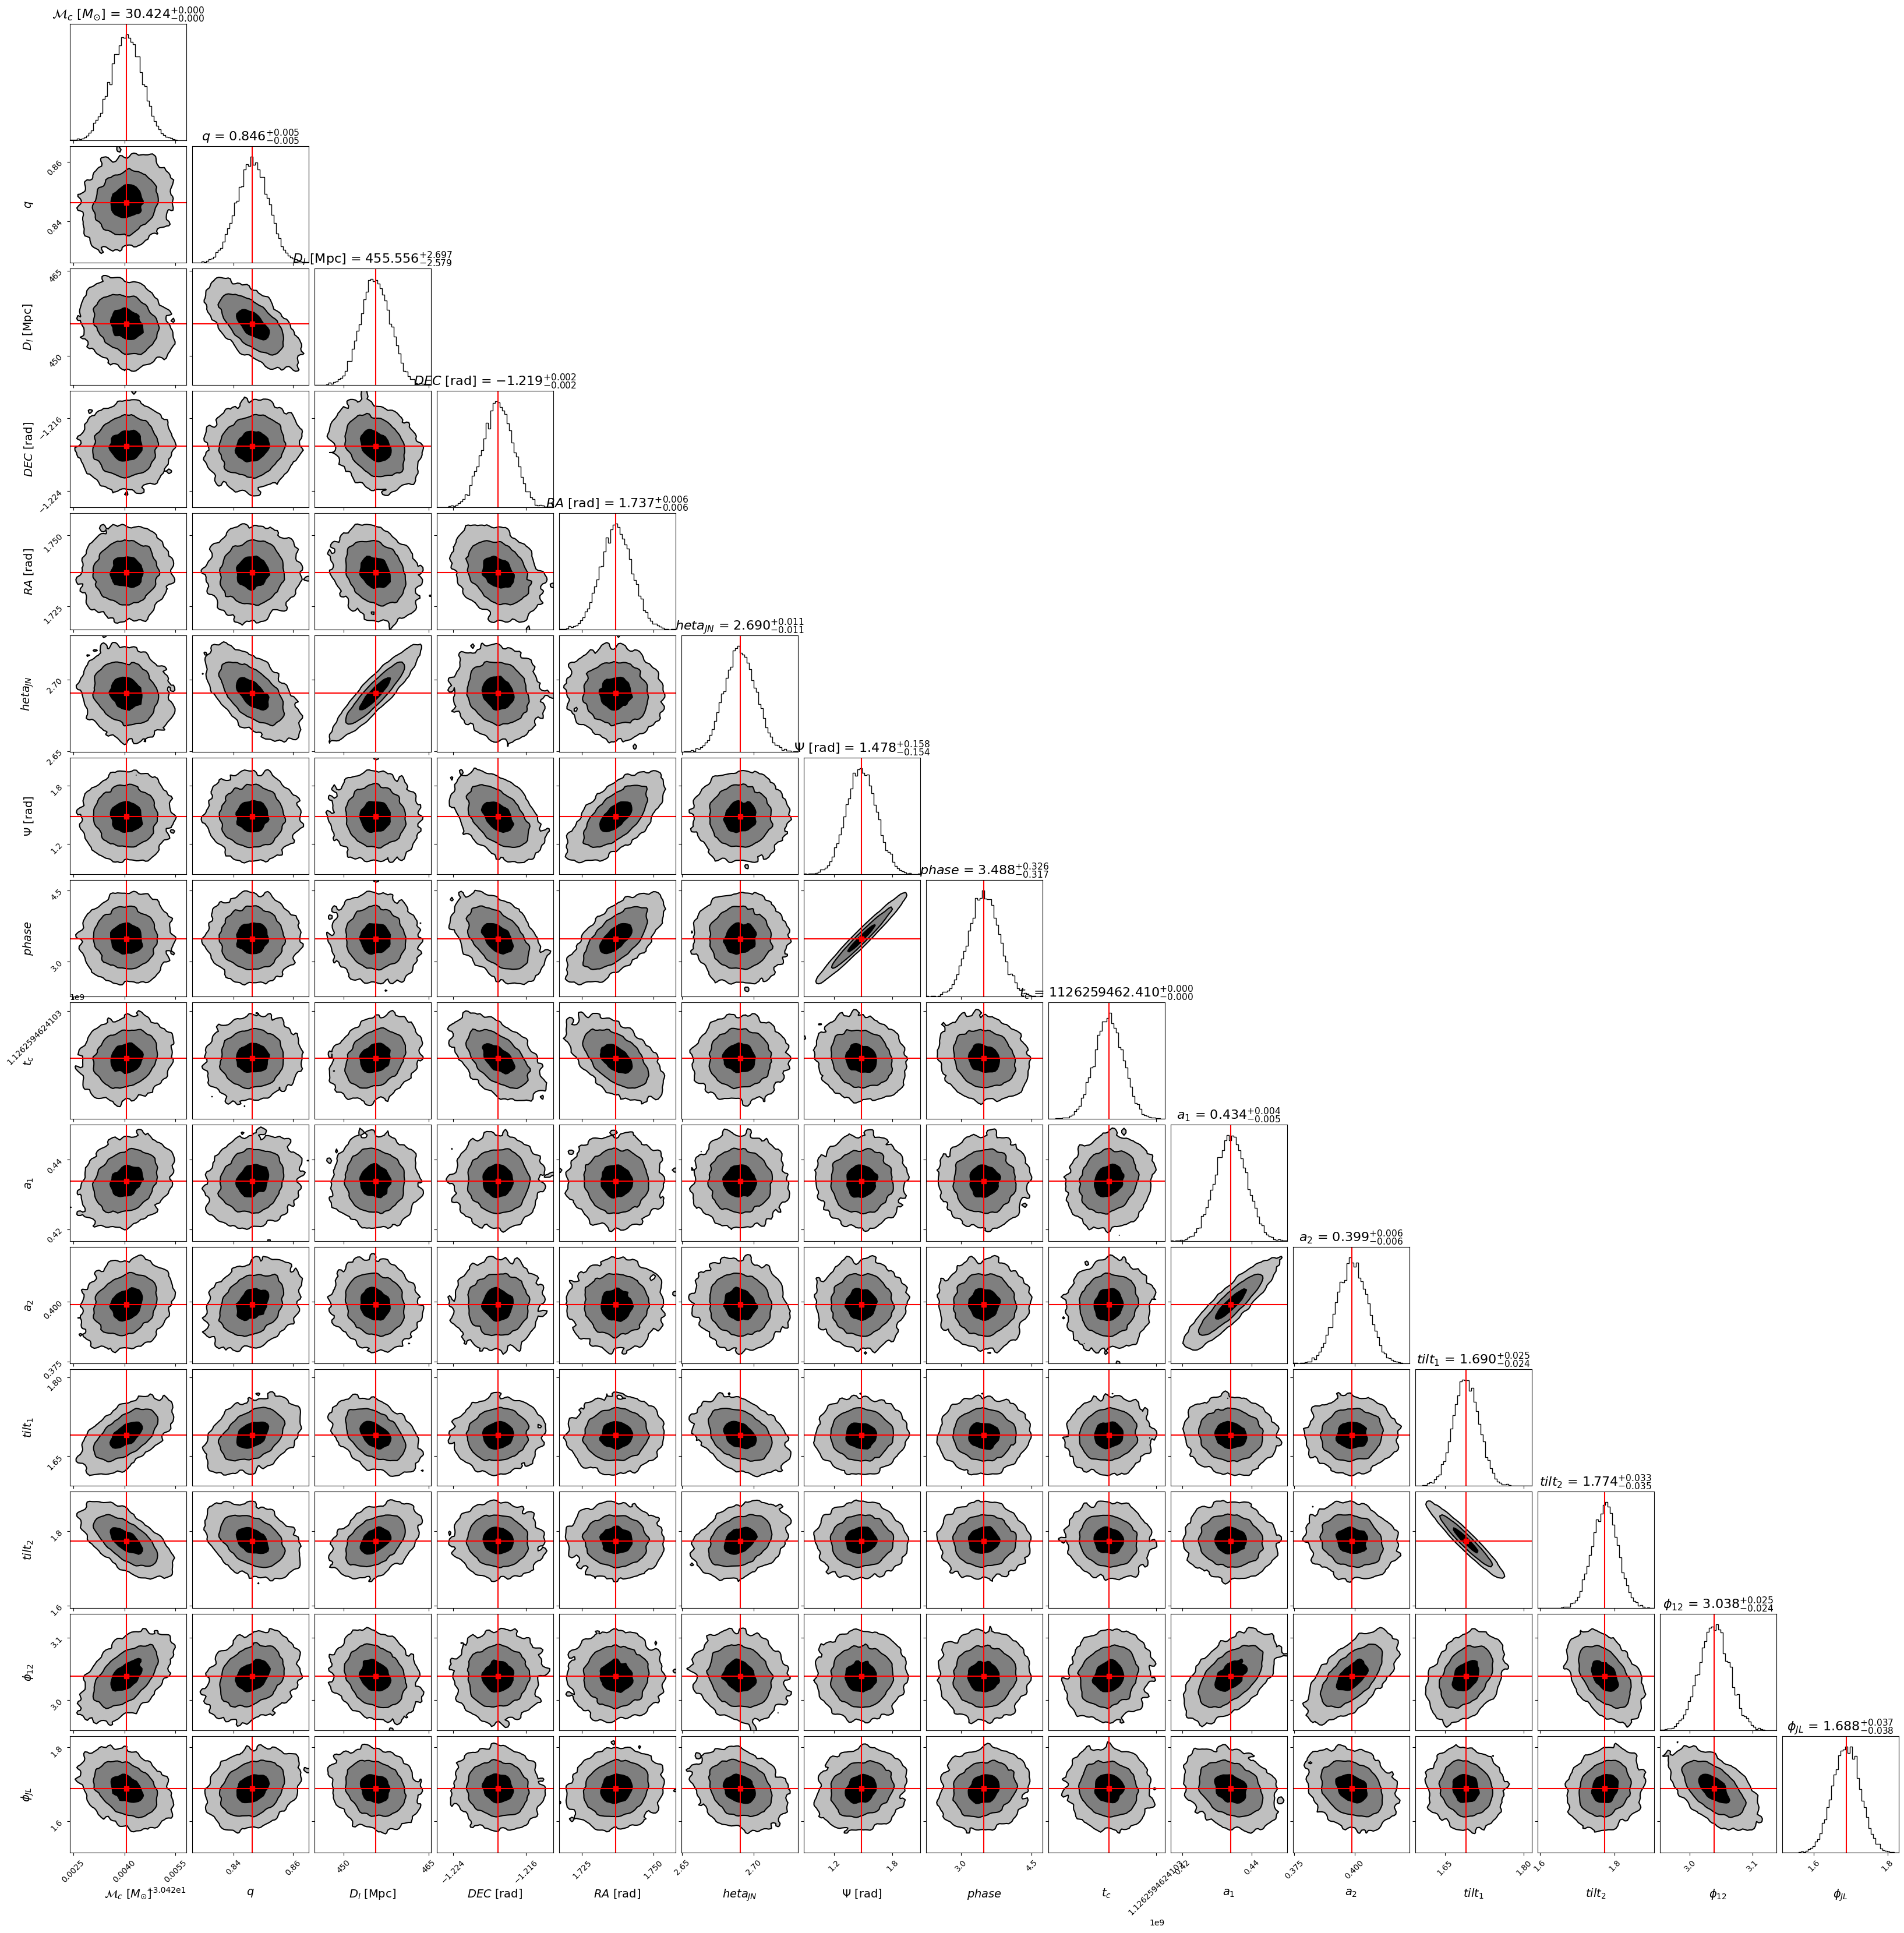

In [43]:
mean_values = parameters.iloc[0] # mean values of the parameters
# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_mat, int(1e4))
fig = corner.corner(samples, labels = corner_lbs, truths = mean_values, truth_color = 'red',
                    **CORNER_KWARGS)
plt.show()

### Equivalent way: results to file

In [23]:
data_folder = 'gwfish_results'
gw.fishermatrix.analyze_and_save_to_txt(network = network,
                                        parameter_values  = parameters,
                                        fisher_parameters = params, 
                                        sub_network_ids_list = [[0]],
                                        population_name = 'BBH',
                                        waveform_model = waveform_model,
                                        save_path = data_folder,
                                        save_matrices = False,
                                        decimal_output_format='%.15f')


  0%|          | 0/1 [00:00<?, ?it/s]100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


## Visualize the signal

In [46]:
# The waveform model can be accessed through the waveform_class attribute,
# which requires the waveform_model and the data_params and the parameters of the event
waveform_class = gw.waveforms.LALFD_Waveform
data_params = {
        'frequencyvector': network.detectors[0].frequencyvector,
        'f_ref': 50.
    }
waveform_obj = waveform_class(waveform_model, parameters.iloc[0], data_params)
wave = waveform_obj()
t_of_f = waveform_obj.t_of_f

# The waveform is then projected onto the detector taking into account the Earth rotation 
# by passing at each frequency step the time of the waveform at the detector
signal = gw.detection.projection(parameters.iloc[0], network.detectors[0], wave, t_of_f)

In [47]:
# The projected amplitude is stored in the signal variable
# We have 3 columns as ET is made of 3 detectors
signal1, signal2, signal3 = signal[:, 0], signal[:, 1], signal[:, 2]
signal_ampl = np.sqrt(np.abs(signal1)**2. + np.abs(signal2)**2. + np.abs(signal3)**2.)

# The PSD of the ET-D detector is stored in the detector_psd folder
# We need to specify the path to the file
et_psd = np.loadtxt('data/ET_psd.txt', usecols=[0, 1])
# frequency vector for the signal
frequencyvector = network.detectors[0].frequencyvector[:, 0]

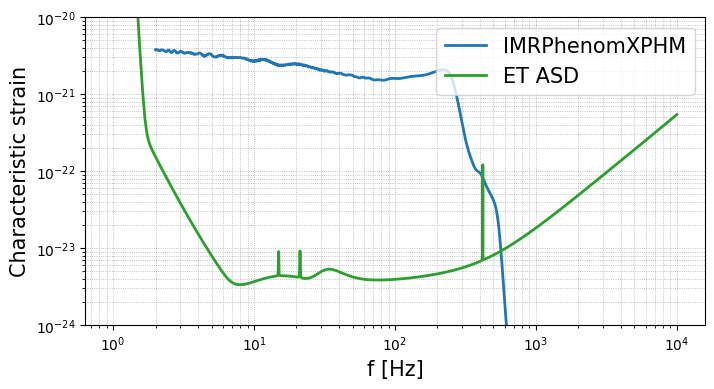

In [50]:

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(frequencyvector, 2. * frequencyvector * signal_ampl, 
        linewidth=2., label='%s' %(waveform_model))
ax.plot(et_psd[:, 0], np.sqrt(et_psd[:, 0]) * np.sqrt(et_psd[:, 1]), linewidth = 2.0, color = 'C2', label = 'ET ASD')
ax.set_ylim(1e-24, 1e-20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('f [Hz]', fontsize=15)
ax.set_ylabel(r'Characteristic strain', fontsize=15)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.legend(loc='upper right', fontsize=15, ncol=1, fancybox=True)

plt.show()

# Population analysis

In [51]:
pop_data = pd.read_hdf('data' + '/' + 'BBH_data_tutorial.hdf5')
pop_data

,chirp_mass,mass_ratio,luminosity_distance,dec,ra,theta_jn,psi,phase,geocent_time,a_1,a_2
0,4.914067,0.894989,129.010054,0.710432,0.513498,1.427815,6.157193,2.725485,1.592697e+09,0.0920,0.0969
1,8.007919,0.817623,166.191775,-0.516538,2.505017,1.672224,3.454403,4.661166,1.596885e+09,0.1550,0.0478
2,16.177536,0.884554,109.198701,0.944427,4.331298,0.868813,5.372557,2.909296,1.600879e+09,0.2251,0.0990
3,16.967558,0.662124,124.853401,0.571092,0.839768,1.366258,4.942905,1.832789,1.588350e+09,0.1605,0.1338
4,14.641519,0.987533,53.657395,-0.694341,2.465576,2.887663,1.568542,1.064090,1.600952e+09,0.0553,0.2164
...,...,...,...,...,...,...,...,...,...,...,...
95,15.136317,0.897465,778.418845,-0.422319,5.918459,2.871478,1.387077,4.823869,1.586253e+09,0.0733,0.1898
96,14.348669,0.879151,784.374752,0.232691,5.700702,0.963563,3.518509,3.222853,1.599641e+09,0.0735,0.1562
97,12.086014,0.566124,862.420224,0.963709,2.544217,2.081882,5.228819,1.953863,1.579086e+09,0.0697,0.1267
98,11.252941,0.896782,837.737116,-0.499535,6.249591,2.115321,2.482802,3.239638,1.590205e+09,0.2386,0.1418


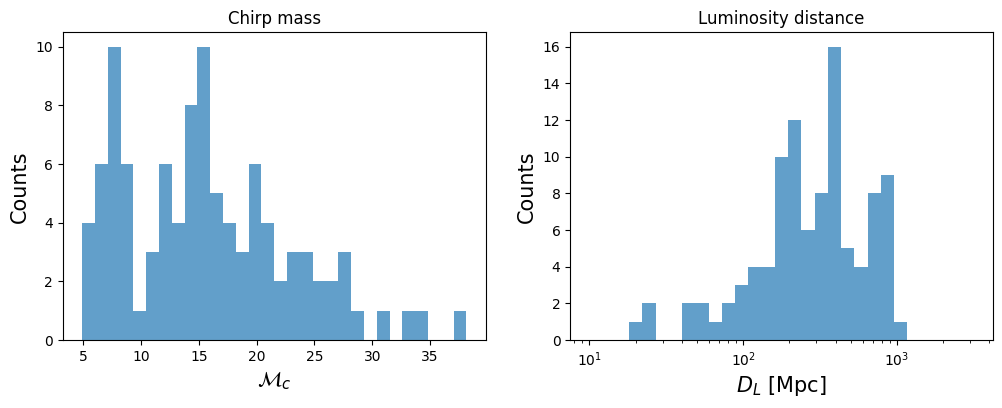

In [56]:
# plot histograms of chirp mass and distance
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(pop_data['chirp_mass'], bins=30, color='C0', alpha=0.7)
ax[0].set_xlabel(r'$\mathcal{M}_c$', fontsize=15)
ax[0].set_ylabel('Counts', fontsize=15)
ax[0].set_title('Chirp mass')

ax[1].hist(pop_data['luminosity_distance'], bins=np.logspace(1, 3.5, 30), color='C0', alpha=0.7)
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$D_L$ [Mpc]', fontsize=15)
ax[1].set_ylabel('Counts', fontsize=15)
ax[1].set_title('Luminosity distance')

plt.show()

In [64]:
params_pop = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 
            'geocent_time', 'a_1', 'a_2']

In [65]:
gw.fishermatrix.analyze_and_save_to_txt(network = network,
                                        parameter_values  = pop_data,
                                        fisher_parameters = params_pop, 
                                        sub_network_ids_list = [[0]],
                                        population_name = 'BBH_pop',
                                        waveform_model = 'IMRPhenomHM',
                                        save_path = 'gwfish_results',
                                        save_matrices = False)

100%|██████████| 100/100 [03:42<00:00,  2.22s/it]


In [66]:
pop_errors = pd.read_csv('gwfish_results' + '/' + 'Errors_ET_BBH_pop_SNR8.txt', delimiter = ' ')
pop_errors

,network_SNR,chirp_mass,mass_ratio,luminosity_distance,dec,ra,theta_jn,psi,phase,geocent_time,...,err_luminosity_distance,err_dec,err_ra,err_theta_jn,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_sky_location
0,189.669424,4.914,0.8950,129.00,0.7104,0.5135,1.4280,6.157,2.725,1.593000e+09,...,17.5500,0.078850,0.072470,0.018870,0.05732,0.10300,0.000732,0.109600,0.124500,9.126000e-03
1,364.548410,8.008,0.8176,166.20,-0.5165,2.5050,1.6720,3.454,4.661,1.597000e+09,...,33.9500,0.268800,0.254000,0.060160,0.08470,0.10680,0.005188,0.041120,0.052450,9.049000e-02
2,3652.561285,16.180,0.8846,109.20,0.9444,4.3310,0.8688,5.373,2.909,1.601000e+09,...,5.4110,0.243000,0.227000,0.005906,0.16370,0.02299,0.001152,0.008192,0.009615,9.975000e-02
3,1127.159611,16.970,0.6621,124.90,0.5711,0.8398,1.3660,4.943,1.833,1.588000e+09,...,22.9300,0.121600,0.138000,0.021580,0.09521,0.04889,0.002016,0.005969,0.009372,4.422000e-02
4,4188.461147,14.640,0.9875,53.66,-0.6943,2.4660,2.8880,1.569,1.064,1.601000e+09,...,0.1874,0.000855,0.001479,0.012910,2.63000,5.26400,0.000009,0.018140,0.018310,7.581000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,359.671875,15.140,0.8975,778.40,-0.4223,5.9180,2.8710,1.387,4.824,1.586000e+09,...,46.2800,0.031340,0.004081,0.114800,20.28000,40.59000,0.000592,0.155600,0.174900,3.479000e-04
96,275.708808,14.350,0.8792,784.40,0.2327,5.7010,0.9636,3.519,3.223,1.600000e+09,...,145.2000,0.221400,0.201200,0.088480,0.43180,0.70330,0.003190,0.060260,0.070360,7.782000e-02
97,130.228470,12.090,0.5661,862.40,0.9637,2.5440,2.0820,5.229,1.954,1.579000e+09,...,101.1000,0.043160,0.089220,0.128300,0.53020,0.69540,0.000748,0.067040,0.113400,4.901000e-03
98,127.697933,11.250,0.8968,837.70,-0.4995,6.2500,2.1150,2.483,3.240,1.590000e+09,...,134.4000,0.059180,0.071390,0.223800,1.02300,1.72900,0.000625,0.191900,0.220900,6.640000e-03


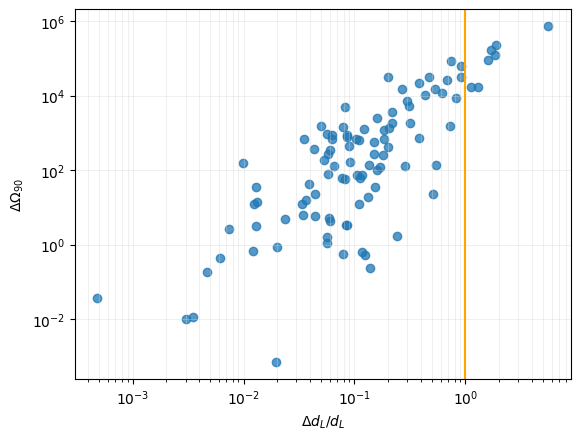

In [72]:
percentile_pop = 90
sky_loc_90cl_pop = pop_errors['err_sky_location'] * gw.fishermatrix.sky_localization_percentile_factor(percentile_pop)
sc = plt.scatter(pop_errors['err_luminosity_distance'] / pop_errors['luminosity_distance'],
                 sky_loc_90cl_pop, color='C0', alpha=0.75)
plt.xscale('log')
plt.yscale('log')
plt.axvline(x=1, color='orange')
plt.xlabel('$\Delta d_L/d_L$')
plt.ylabel('$\Delta \Omega_{%s}$' %int(percentile))
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()

In [78]:
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
import astropy.units as u

cosmo = FlatLambdaCDM(H0=67.66 , Om0=0.30966) #Planck18

redshift = z_at_value(cosmo.luminosity_distance, pop_data['luminosity_distance'].to_numpy()*u.Mpc) 

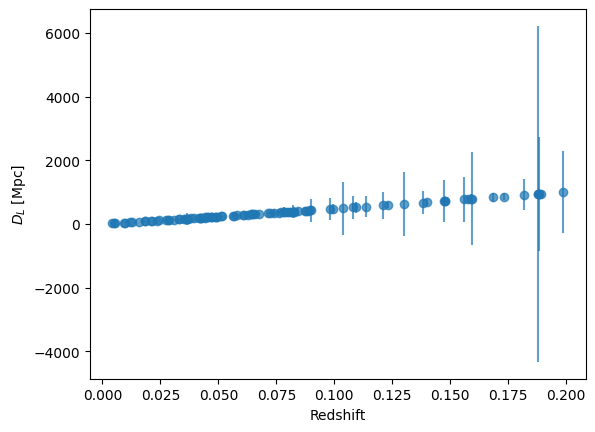

In [79]:
plt.errorbar(redshift, pop_data['luminosity_distance'], yerr=pop_errors['err_luminosity_distance'], fmt='o', color='C0', alpha=0.7)
plt.xlabel('Redshift')
plt.ylabel(r'$D_L$ [Mpc]')
plt.show()